# 05: Training the ML algorithm

In [1]:
import SMEFT19

In [2]:
d = SMEFT19.ellipse.load('../data/ellipses/rotBII.yaml')

In [3]:
ML = SMEFT19.ml.train(['../data/samples/randompoints.dat', '../data/samples/samplealbl.dat', '../data/samples/sampleaqbq.dat'],
                 '../data/samples/validationpoints.dat', '../data/MLmodels/xgb_lh.json', d['bf'], headers=0)

[0]	validation_0-rmse:16.91280
[1]	validation_0-rmse:16.09133
[2]	validation_0-rmse:15.31251
[3]	validation_0-rmse:14.57173
[4]	validation_0-rmse:13.86667
[5]	validation_0-rmse:13.19782
[6]	validation_0-rmse:12.56034
[7]	validation_0-rmse:11.95648
[8]	validation_0-rmse:11.38294
[9]	validation_0-rmse:10.83870
[10]	validation_0-rmse:10.32351
[11]	validation_0-rmse:9.83251
[12]	validation_0-rmse:9.36840
[13]	validation_0-rmse:8.92657
[14]	validation_0-rmse:8.50857
[15]	validation_0-rmse:8.11116
[16]	validation_0-rmse:7.73712
[17]	validation_0-rmse:7.38020
[18]	validation_0-rmse:7.04063
[19]	validation_0-rmse:6.71879
[20]	validation_0-rmse:6.41390
[21]	validation_0-rmse:6.12640
[22]	validation_0-rmse:5.85197
[23]	validation_0-rmse:5.59390
[24]	validation_0-rmse:5.34946
[25]	validation_0-rmse:5.11636
[26]	validation_0-rmse:4.89719
[27]	validation_0-rmse:4.68810
[28]	validation_0-rmse:4.48815
[29]	validation_0-rmse:4.29929
[30]	validation_0-rmse:4.11894
[31]	validation_0-rmse:3.95189
[32]	va

[260]	validation_0-rmse:0.91116
[261]	validation_0-rmse:0.91081
[262]	validation_0-rmse:0.91096
[263]	validation_0-rmse:0.91092
[264]	validation_0-rmse:0.90864
[265]	validation_0-rmse:0.90750
[266]	validation_0-rmse:0.90737
[267]	validation_0-rmse:0.90661
[268]	validation_0-rmse:0.90638
[269]	validation_0-rmse:0.90620
[270]	validation_0-rmse:0.90553
[271]	validation_0-rmse:0.90561
[272]	validation_0-rmse:0.90536
[273]	validation_0-rmse:0.90522
[274]	validation_0-rmse:0.90321
[275]	validation_0-rmse:0.90276
[276]	validation_0-rmse:0.90238
[277]	validation_0-rmse:0.90175
[278]	validation_0-rmse:0.90059
[279]	validation_0-rmse:0.89942
[280]	validation_0-rmse:0.89945
[281]	validation_0-rmse:0.89945
[282]	validation_0-rmse:0.89918
[283]	validation_0-rmse:0.89919
[284]	validation_0-rmse:0.89817
[285]	validation_0-rmse:0.89690
[286]	validation_0-rmse:0.89644
[287]	validation_0-rmse:0.89357
[288]	validation_0-rmse:0.89348
[289]	validation_0-rmse:0.89122
[290]	validation_0-rmse:0.88898
[291]	va

## Linear regression

Here we check that the ML approximation correctly reproduces the likelihood of the datapoints

PearsonRResult(statistic=0.9736190946668213, pvalue=0.0)

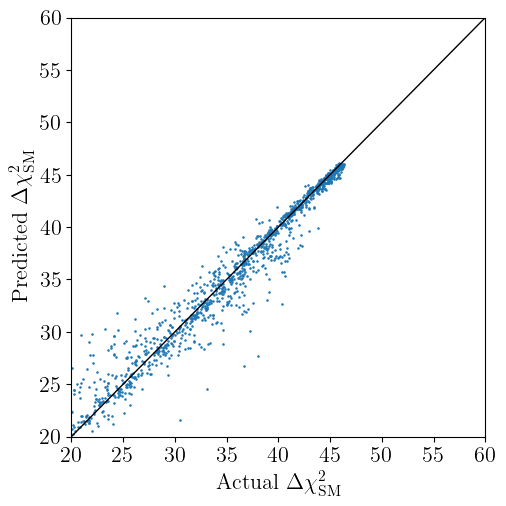

In [4]:
SMEFT19.ml.regr(ML, '../data/samples/validationpoints.dat', '../data/plots/regression_xgb')

## Distribution

Now we generate a small sample of points with a Montecarlo algorithm using the ML-approximation of the likelihood

In [11]:
newpoints = ML.newpoints(500)
df = pd.DataFrame(newpoints)
preds = ML.model.predict(df)

In [5]:
import matplotlib.pyplot as plt
from scipy.stats import chi2
import numpy as np

And compare the resulting histogram with the p.d.f of a $\chi^2$ distribution with 5 degrees of freedom

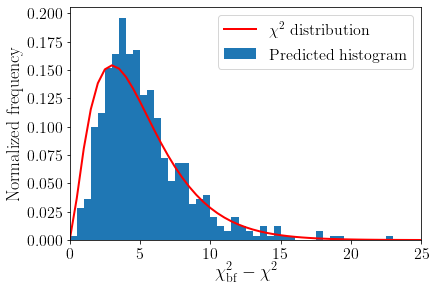

In [29]:
_ = plt.hist(2*max(preds) - 2*preds, bins=50, range=(0,25), density=True, label='Predicted histogram')
plt.plot(np.linspace(0,25,51), chi2(5).pdf(np.linspace(0,25,51)), label=r'$\chi^2$ distribution', lw=2, c='r')
plt.xlim([0,25])
plt.xlabel(r'$\chi^2_\mathrm{bf} - \chi^2$', fontsize=18)
plt.ylabel('Normalized frequency', fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout(pad=0.5)
plt.savefig('../data/plots/hist_xgb.pdf')
plt.savefig('../data/plots/hist_xgb.pgf')

## SHAP

In [32]:
newpoints += ML.newpoints(500)

In [16]:
ML = SMEFT19.ml.load_model('../data/MLmodels/xgb_lh.json', '../data/samples/validationpoints.dat', d['bf'])

In [17]:
dfnewpoints = pd.DataFrame(newpoints, columns=['C', 'al', 'bl', 'aq', 'bq'])
dfnewpoints['logL'] = ML.model.predict(dfnewpoints)
dfnewpoints.to_csv('../data/samples/mlpoints.dat', sep='\t', index=False)

In [37]:
SMEFT19.ml.SHAP_bf('../data/MLmodels/xgb_lh.json', d['bf'])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Base value: 19.718127893342555
SHAP values: [[1.6465868 2.0282266 0.9966447 1.3356845 2.0434434]]
Total prediction: 27.768725395202637


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


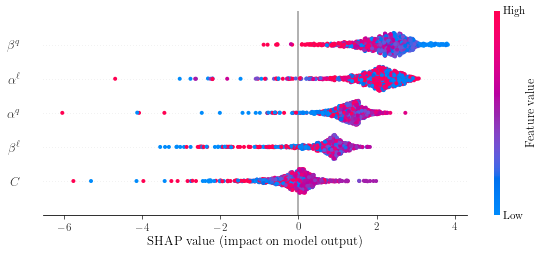

In [3]:
SMEFT19.ml.SHAP_summary('../data/MLmodels/xgb_lh.json', '../data/samples/mlpoints.dat', '../data/plots/SHAP_summary', 0)

In [4]:
import matplotlib.pyplot as plt
import numpy as np

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.


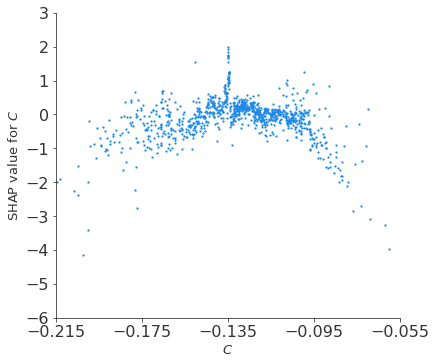

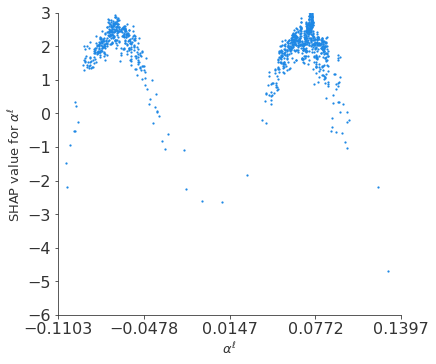

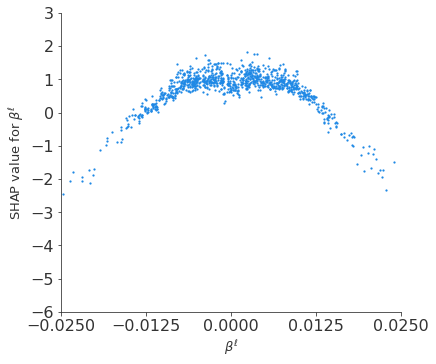

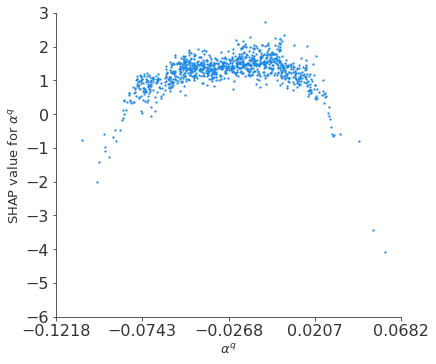

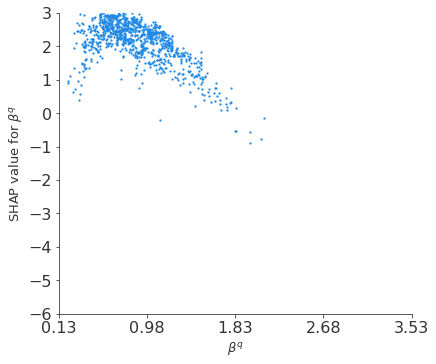

In [8]:
names = ['C', 'al', 'bl', 'aq', 'bq']
ranges = [[-0.08, 0.08], [-0.18, 0.07], [-0.025, 0.025], [-0.07, 0.12], [-0.6,2.8]]
for i in range(5):
    SMEFT19.ml.SHAP_param('../data/MLmodels/xgb_lh.json', '../data/samples/mlpoints.dat', i, 0)
    ax = plt.gca()
    plt.xlim([d['bf'][i]+ranges[i][0], d['bf'][i]+ranges[i][1]])
    ax.set_xticks(np.linspace(d['bf'][i]+ranges[i][0], d['bf'][i]+ranges[i][1], 5))
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.tight_layout(pad=0.5)
    plt.savefig(f'../data/plots/SHAP_{names[i]}.pdf')